In [17]:
import numpy as np
import matplotlib.pyplot as plt
from Model import KMeans
from matplotlib.patches import Circle
import pandas as pd
import math

The goal of k-means is to partition a dataset into k clusters in such a way that the sum of the squared distances between the data points and their assigned cluster centroids is minimized.

In [2]:
def plot_kmeans_clusters(X, centroids, labels, nstd=2, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    for i in range(centroids.shape[0]):
        points_in_cluster = X[labels == i]
        if points_in_cluster.shape[0] > 0:
            avg_distance = np.mean(np.sqrt(np.sum((points_in_cluster - centroids[i])**2, axis=1)))
            circle = Circle(centroids[i], avg_distance * nstd, color='red', fill=False, linestyle='--', linewidth=2)
            ax.add_patch(circle)

    return ax


In [3]:
def normalization(data):
    demean = data - data.mean()
    unit_variance = demean / data.std()
    return unit_variance

In [4]:
def load_data(dataset_path):
    data = pd.read_csv("Datasets/"+ dataset_path)
    y_true = data['class']
    data = data.drop('class', axis=1)
    return data, y_true

In [5]:
def destandardize(data, mean, std):
    return data * std + mean

In [ ]:
datasets_path = ['banana.csv','blobs.csv','dartboard2.csv','elliptical.csv','twenty.csv']
datasets = []
metrics = []
for dataset_path in datasets_path:
    data, labels = load_data(dataset_path)
    metrics.append((data.mean(),data.std()))
    data = normalization(data)
    datasets.append((data,labels))

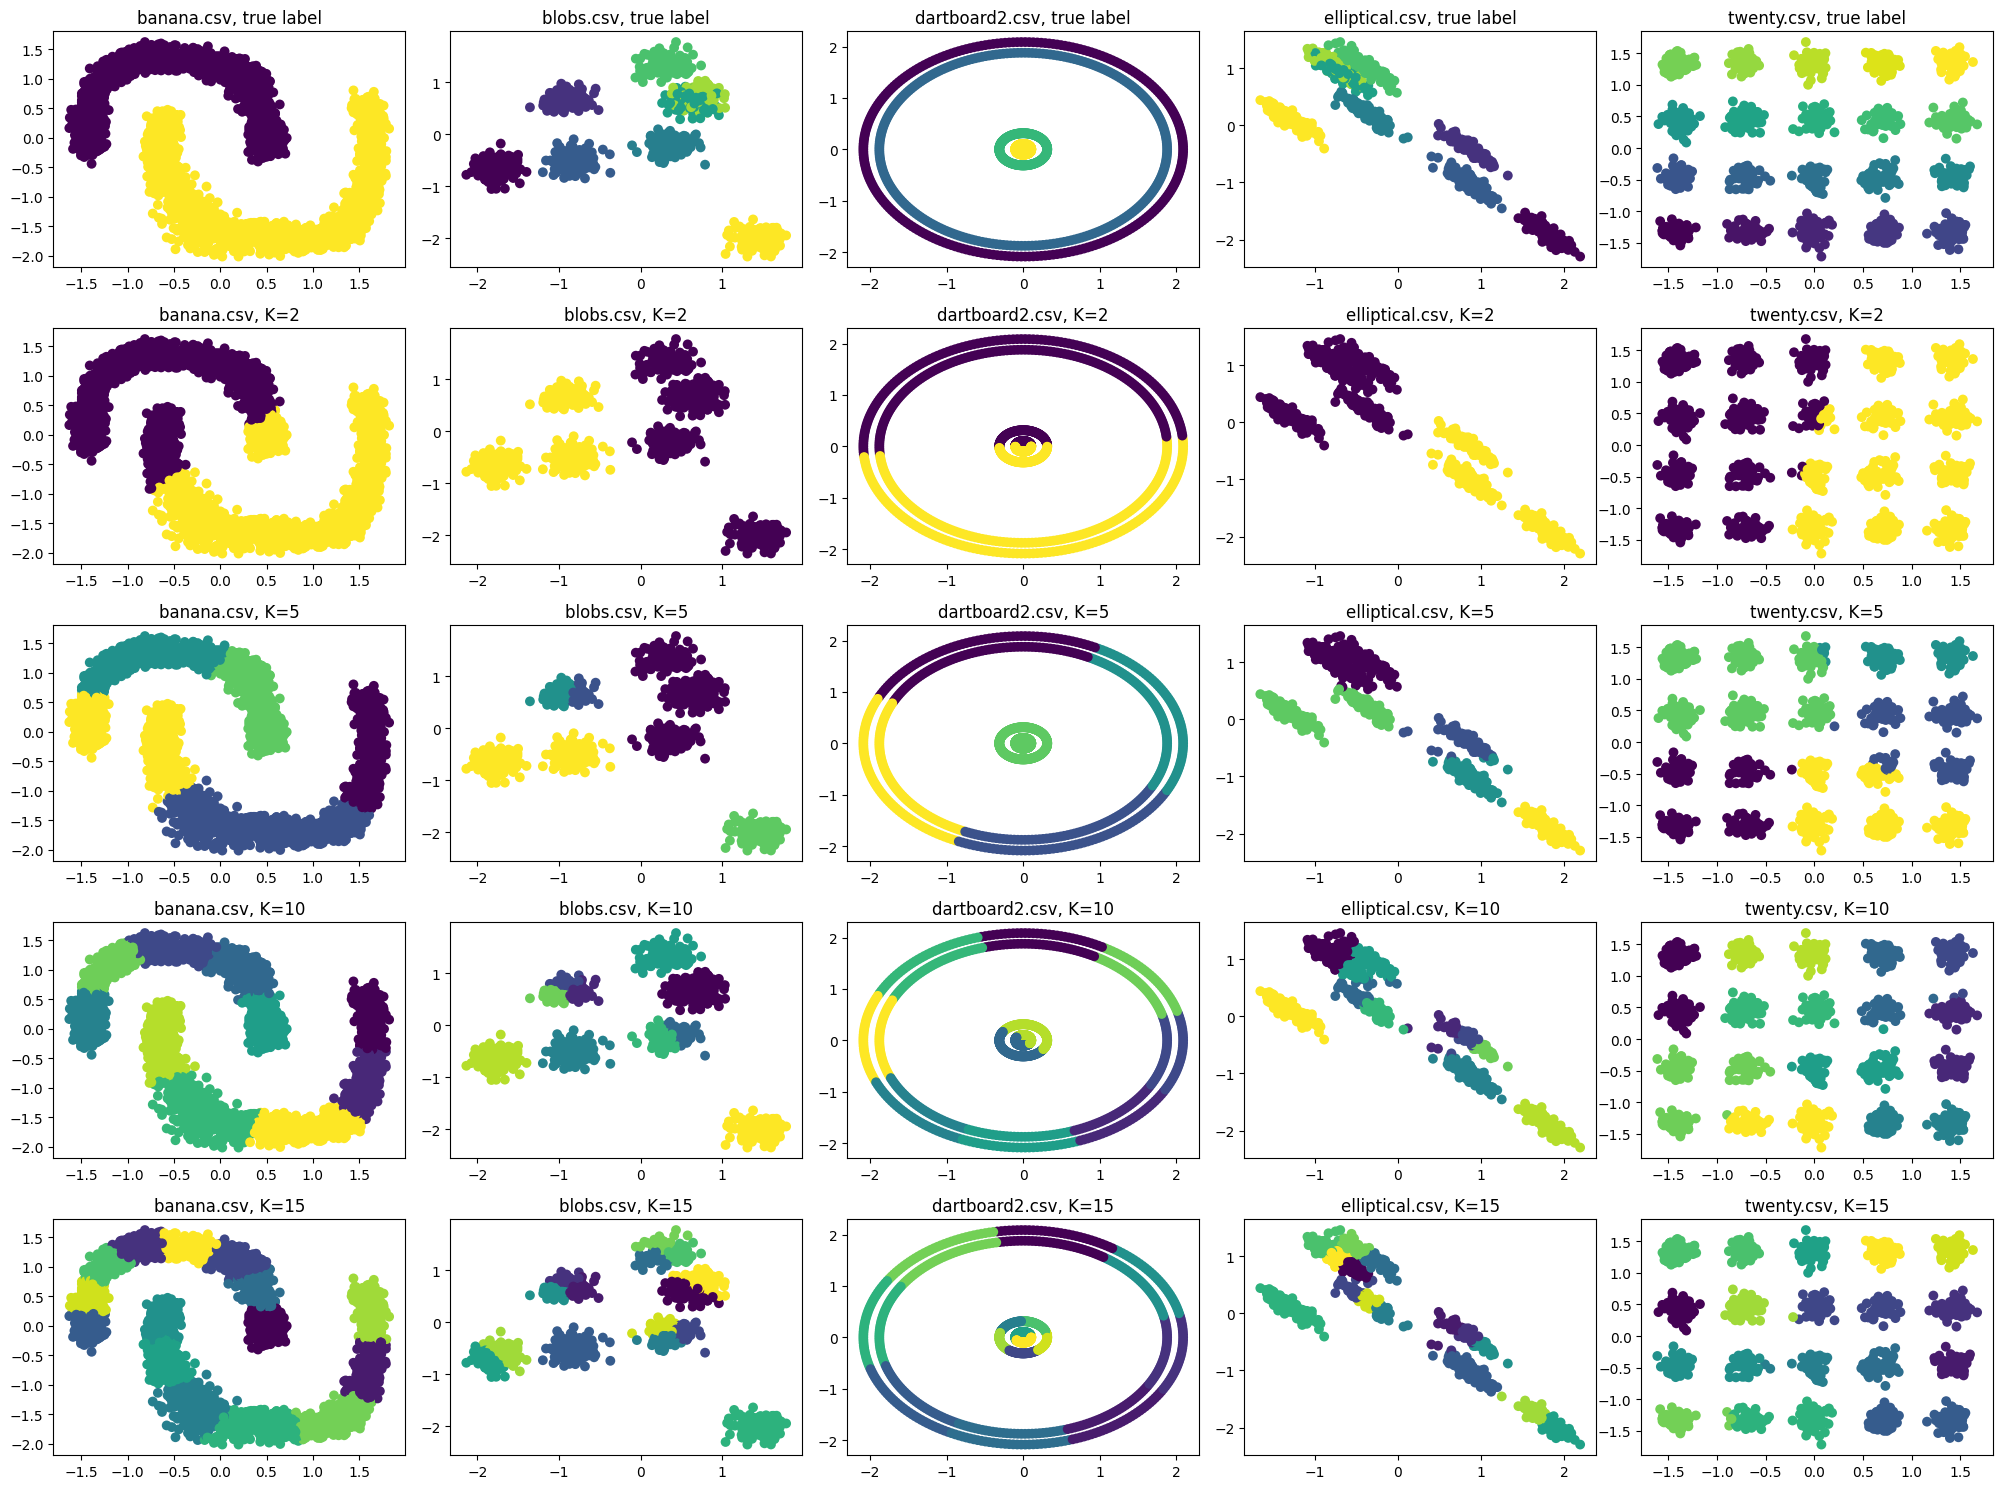

In [50]:
k_values = [2,5,10,15]

fig, axs = plt.subplots(len(k_values)+1, len(datasets), figsize=(20, 15))
for j, (dataset, labels) in enumerate(datasets):
    axs[0, j].scatter(dataset.iloc[:, 0], dataset.iloc[:, 1], c=labels, cmap='viridis', s=50, edgecolors='k', linewidth=0)
    axs[0, j].set_title(f'{datasets_path[j]}, true label')
    
for i, k in enumerate(k_values):
    for j, (dataset, labels) in enumerate(datasets):
        kmeans = KMeans(k, random_state=42)
        y_pred = kmeans.fit_predict(np.array(dataset))
        axs[i+1, j].scatter(dataset.iloc[:, 0], dataset.iloc[:, 1], c=y_pred, cmap='viridis', s=50, edgecolors='k', linewidth=0)
#         plot_kmeans_clusters(dataset, kmeans.centroids, y_pred, ax=axs[i, j])
        axs[i+1, j].set_title(f'{datasets_path[j]}, K={k}')

plt.tight_layout()
plt.show()

WCSS = Within-Cluster Sum of Squares:

$$ WCSS = \sum_{i=1}^{k} \sum_{j=1}^{n_i} \| x_{ij} - c_i \|^2 $$
WCSS is primarily used for selecting the optimal number of clusters (k) in algorithms like k-means, where the goal is to minimize the sum of squared distances between data points and their assigned cluster centroids.

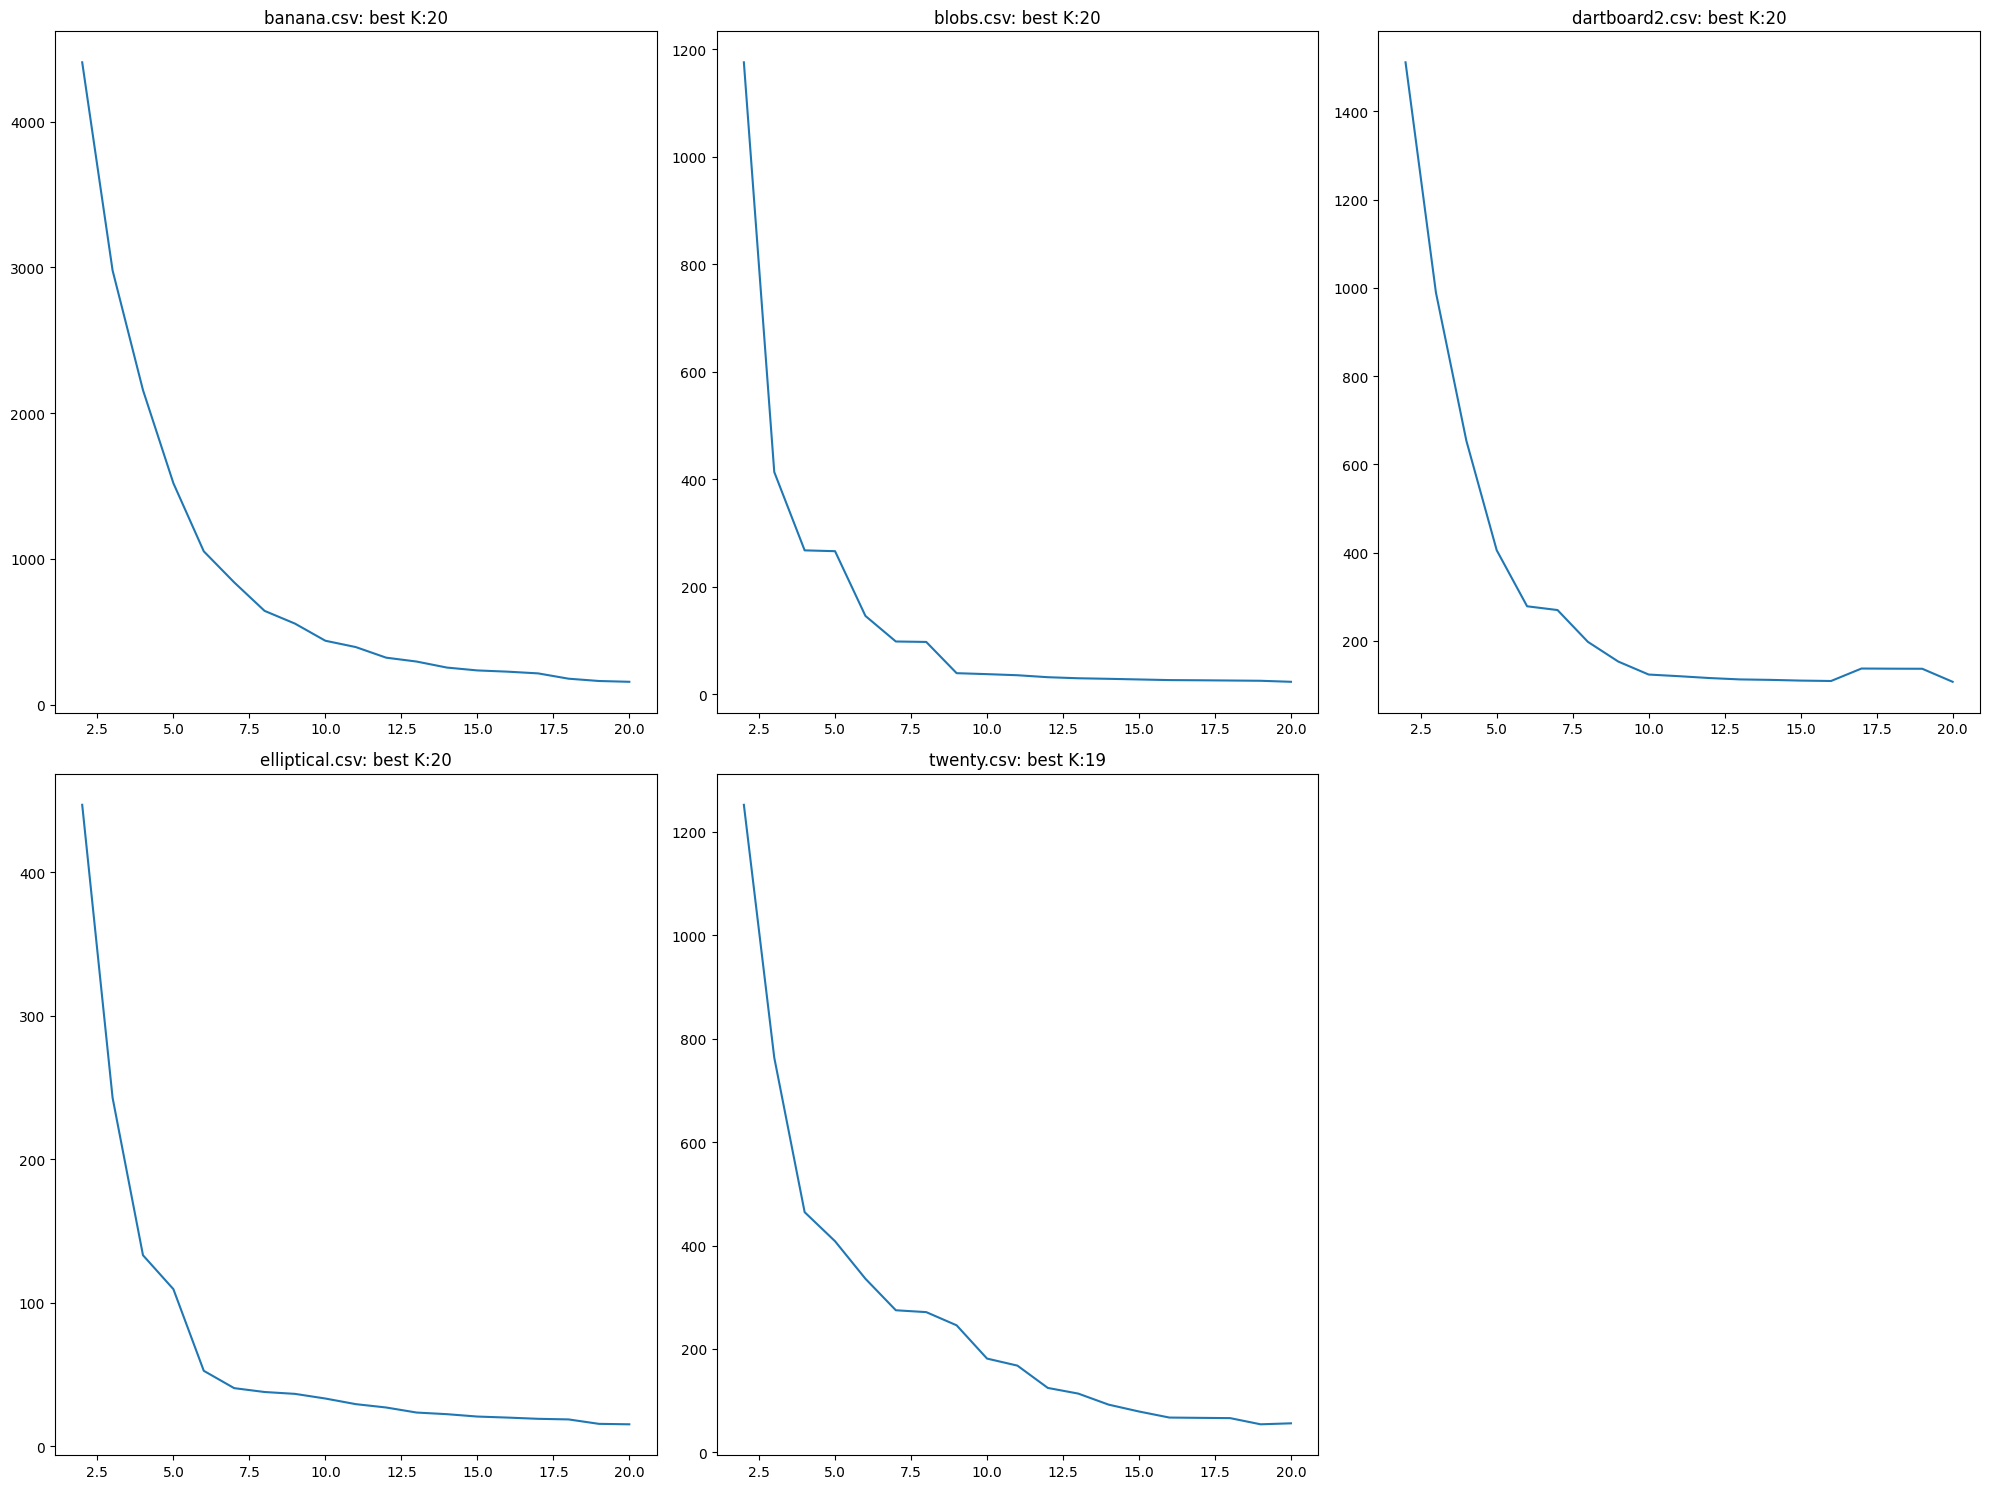

In [44]:
num_datasets = len(datasets)
num_rows = int(np.ceil(num_datasets / 3))  
wcss_best_k = []
fig, axs = plt.subplots(num_rows, 3, figsize=(20, 15))  
for i, (dataset, y_true) in enumerate(datasets):
    wcss = []
    X = dataset.values
    for k in range(2, 21):  
        kmeans = KMeans(n_clusters=k, max_iter=300, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    row_idx = i // 3
    col_idx = i % 3
    axs[row_idx, col_idx].plot(list(range(2, 21)), wcss)
    best_k = np.argmin(wcss)+2
    axs[row_idx, col_idx].set_title(f'{datasets_path[i]}: best K:{best_k}')
    wcss_best_k.append(best_k)

for j in range(i + 1, num_rows * 3):
    axs[j // 3, j % 3].axis('off')

plt.tight_layout()
plt.show()

Davies Bouldin Index(DBI):
It measures the compactness and separation between clusters. Lower values of DBI indicate better clustering solutions.
The DBI is defined for a specific cluster i as the average similarity-to-dissimilarity ratio over all other clusters j. 
S_i​ is the average distance of all points in cluster i to the centroid of cluster i.
M_ij​ is the distance between the centroids of clusters i and j.
The DBI assesses how well-separated clusters are from each other, while also considering the compactness of individual clusters.
The max identifies the cluster that has the highest similarity-to-dissimilarity ratio with the current cluster ii.

$$ \text{DBI} = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{S_i + S_j}{M_{ij}} \right) $$

In [18]:
def davies_bouldin_score(X, labels, centroids):
    n_clusters = len(centroids)
    cluster_distances = np.zeros(n_clusters)
    for i in range(n_clusters):
        points_in_cluster = X[labels == i]
        if len(points_in_cluster) == 0:
            continue
        cluster_distances[i] = np.mean([math.dist(point, centroids[i]) for point in points_in_cluster])

    db_index = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i != j:
                db_index[i, j] = (cluster_distances[i] + cluster_distances[j]) / math.dist(centroids[i], centroids[j])

    db_index[db_index == np.inf] = 0
    db_index[np.isnan(db_index)] = 0
    dbi = np.mean(np.max(db_index, axis=1))
    return dbi

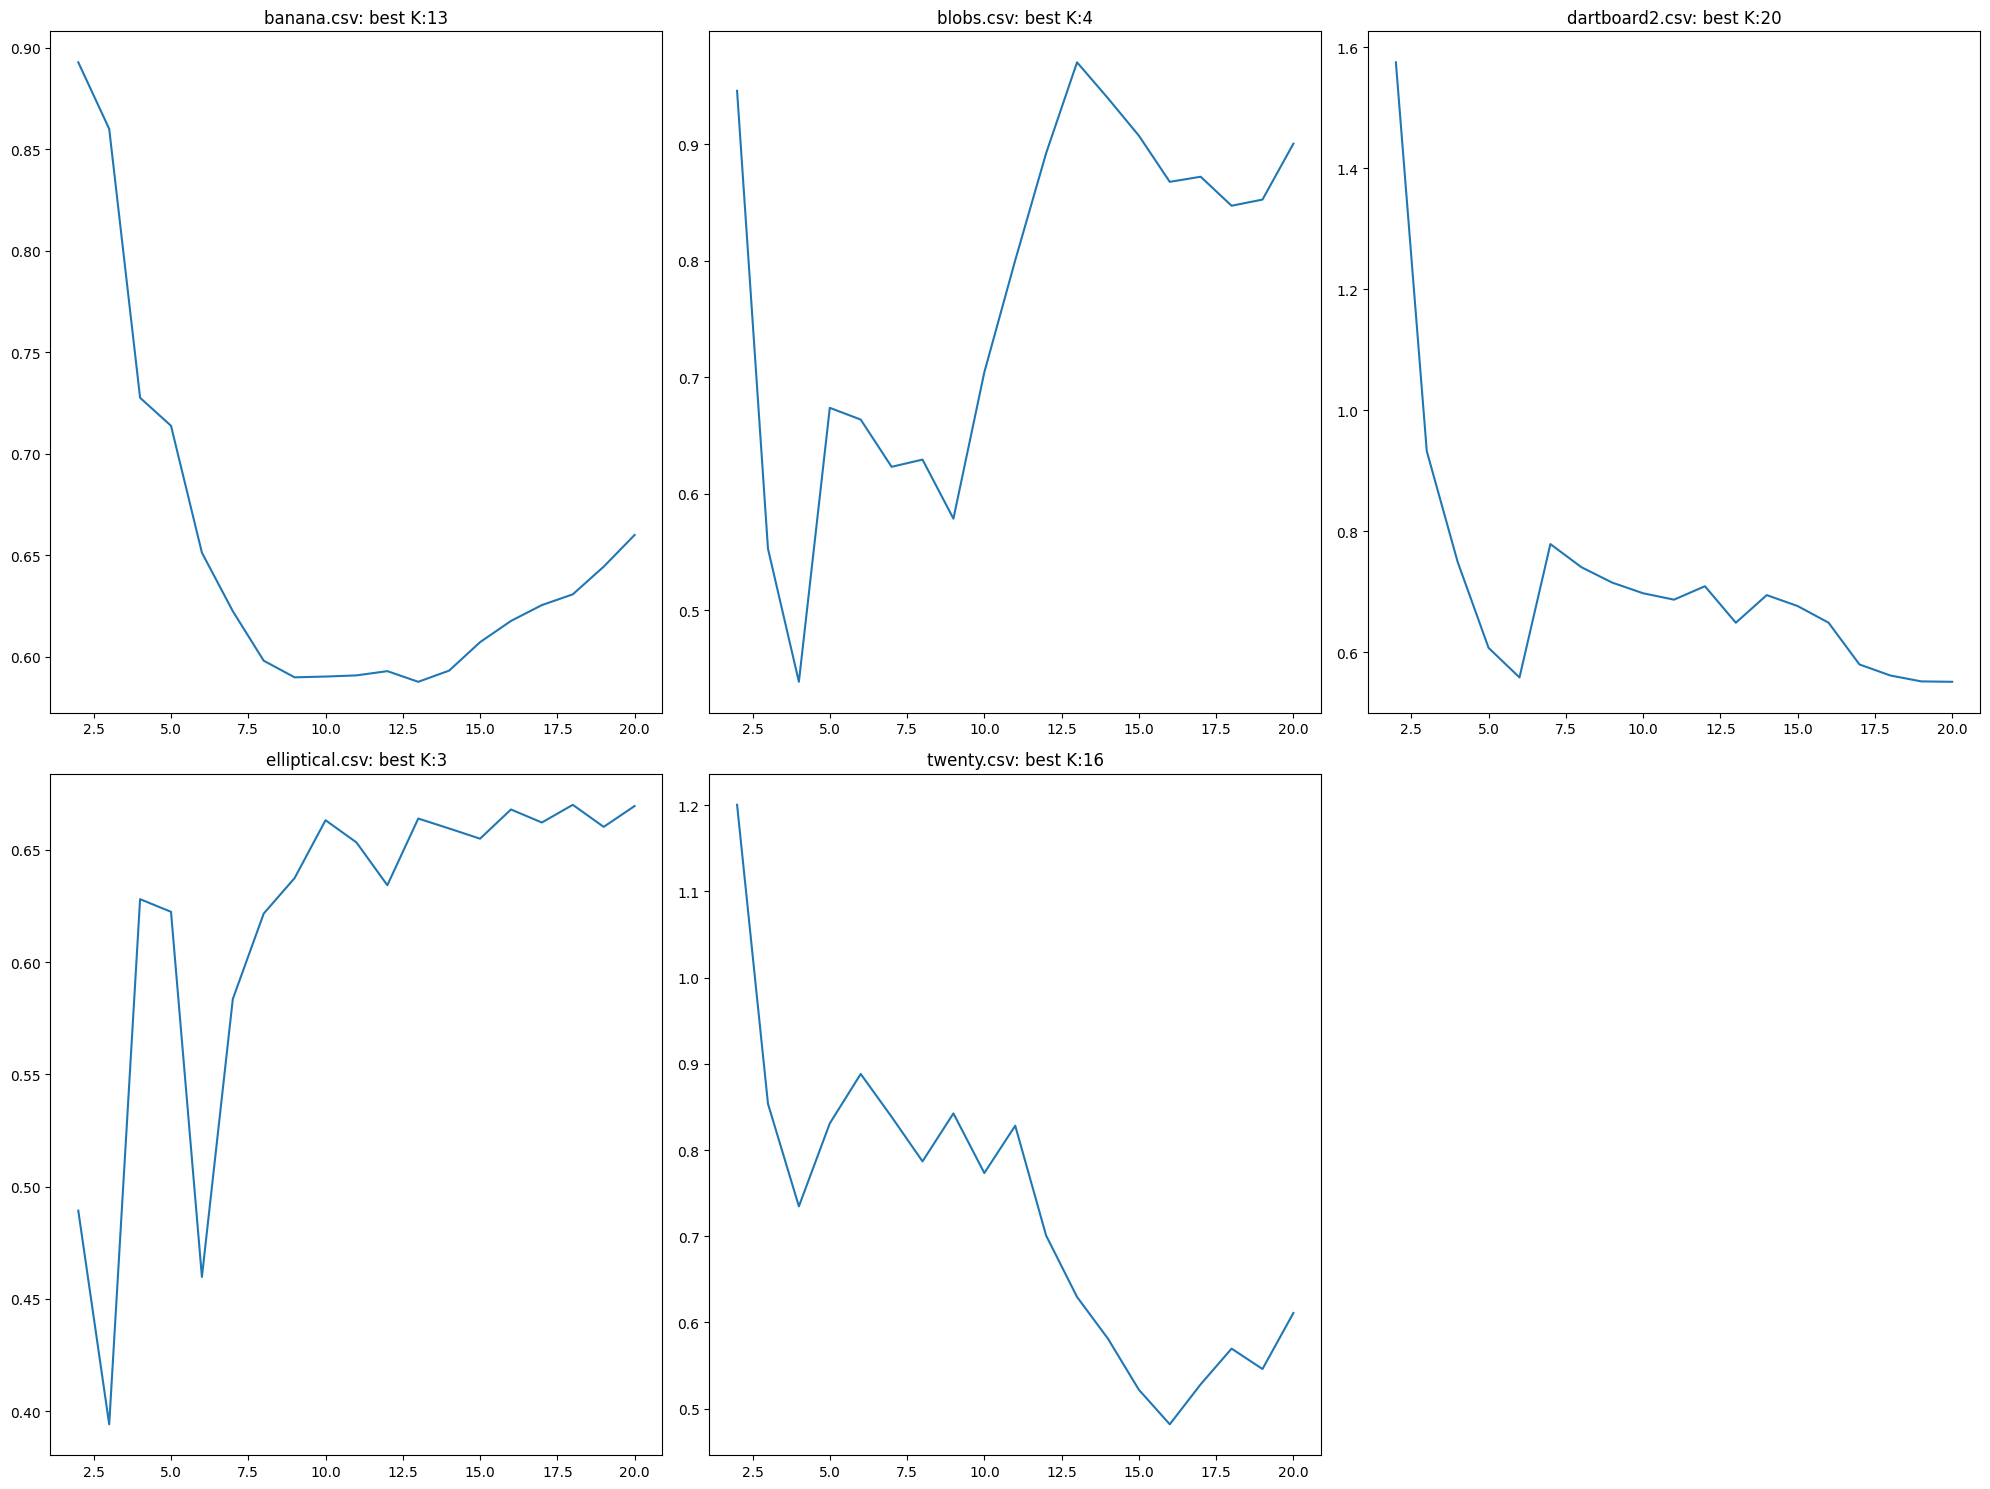

In [43]:
num_datasets = len(datasets)
num_rows = int(np.ceil(num_datasets / 3))  

fig, axs = plt.subplots(num_rows, 3, figsize=(20, 15))  
dbi_best_k = []
for i, (dataset, y_true) in enumerate(datasets):
    X = dataset.values
    dbi_scores = []

    for k in range(2, 21):
        kmeans = KMeans(n_clusters=k, max_iter=300, random_state=42)
        kmeans.fit(X)
        dbi = davies_bouldin_score(X, kmeans.labels_, kmeans.centroids)
        dbi_scores.append(dbi)

    row_idx = i // 3
    col_idx = i % 3
    axs[row_idx, col_idx].plot(list(range(2, 21)), dbi_scores)
    best_k = np.argmin(dbi_scores) + 2
    axs[row_idx, col_idx].set_title(f'{datasets_path[i]}: best K:{best_k}')
    dbi_best_k.append(best_k)
    

for j in range(i + 1, num_rows * 3):
    axs[j // 3, j % 3].axis('off')

plt.tight_layout()
plt.show()

1. **WCSS Emphasizes Compactness:** WCSS is more sensitive to the compactness of clusters. If your datasets tend to have well-defined, tight clusters, WCSS might consistently suggest the same optimal k.

2. **DBI Considers both Compactness and Separation:** DBI, on the other hand, takes into account both the compactness of clusters and the separation between them. If your datasets have clusters that are not well-separated or have irregular shapes, DBI might provide a more nuanced evaluation.

3. **Data Characteristics:** Different datasets with distinct characteristics may lead to different optimal k values based on how well-defined and separated the clusters are.

4. **Sensitivity to Noise and Outliers:** WCSS is sensitive to noise and outliers, as it aims to minimize the sum of squared distances. DBI, by considering the ratio between clusters, might be more robust to the influence of outliers.


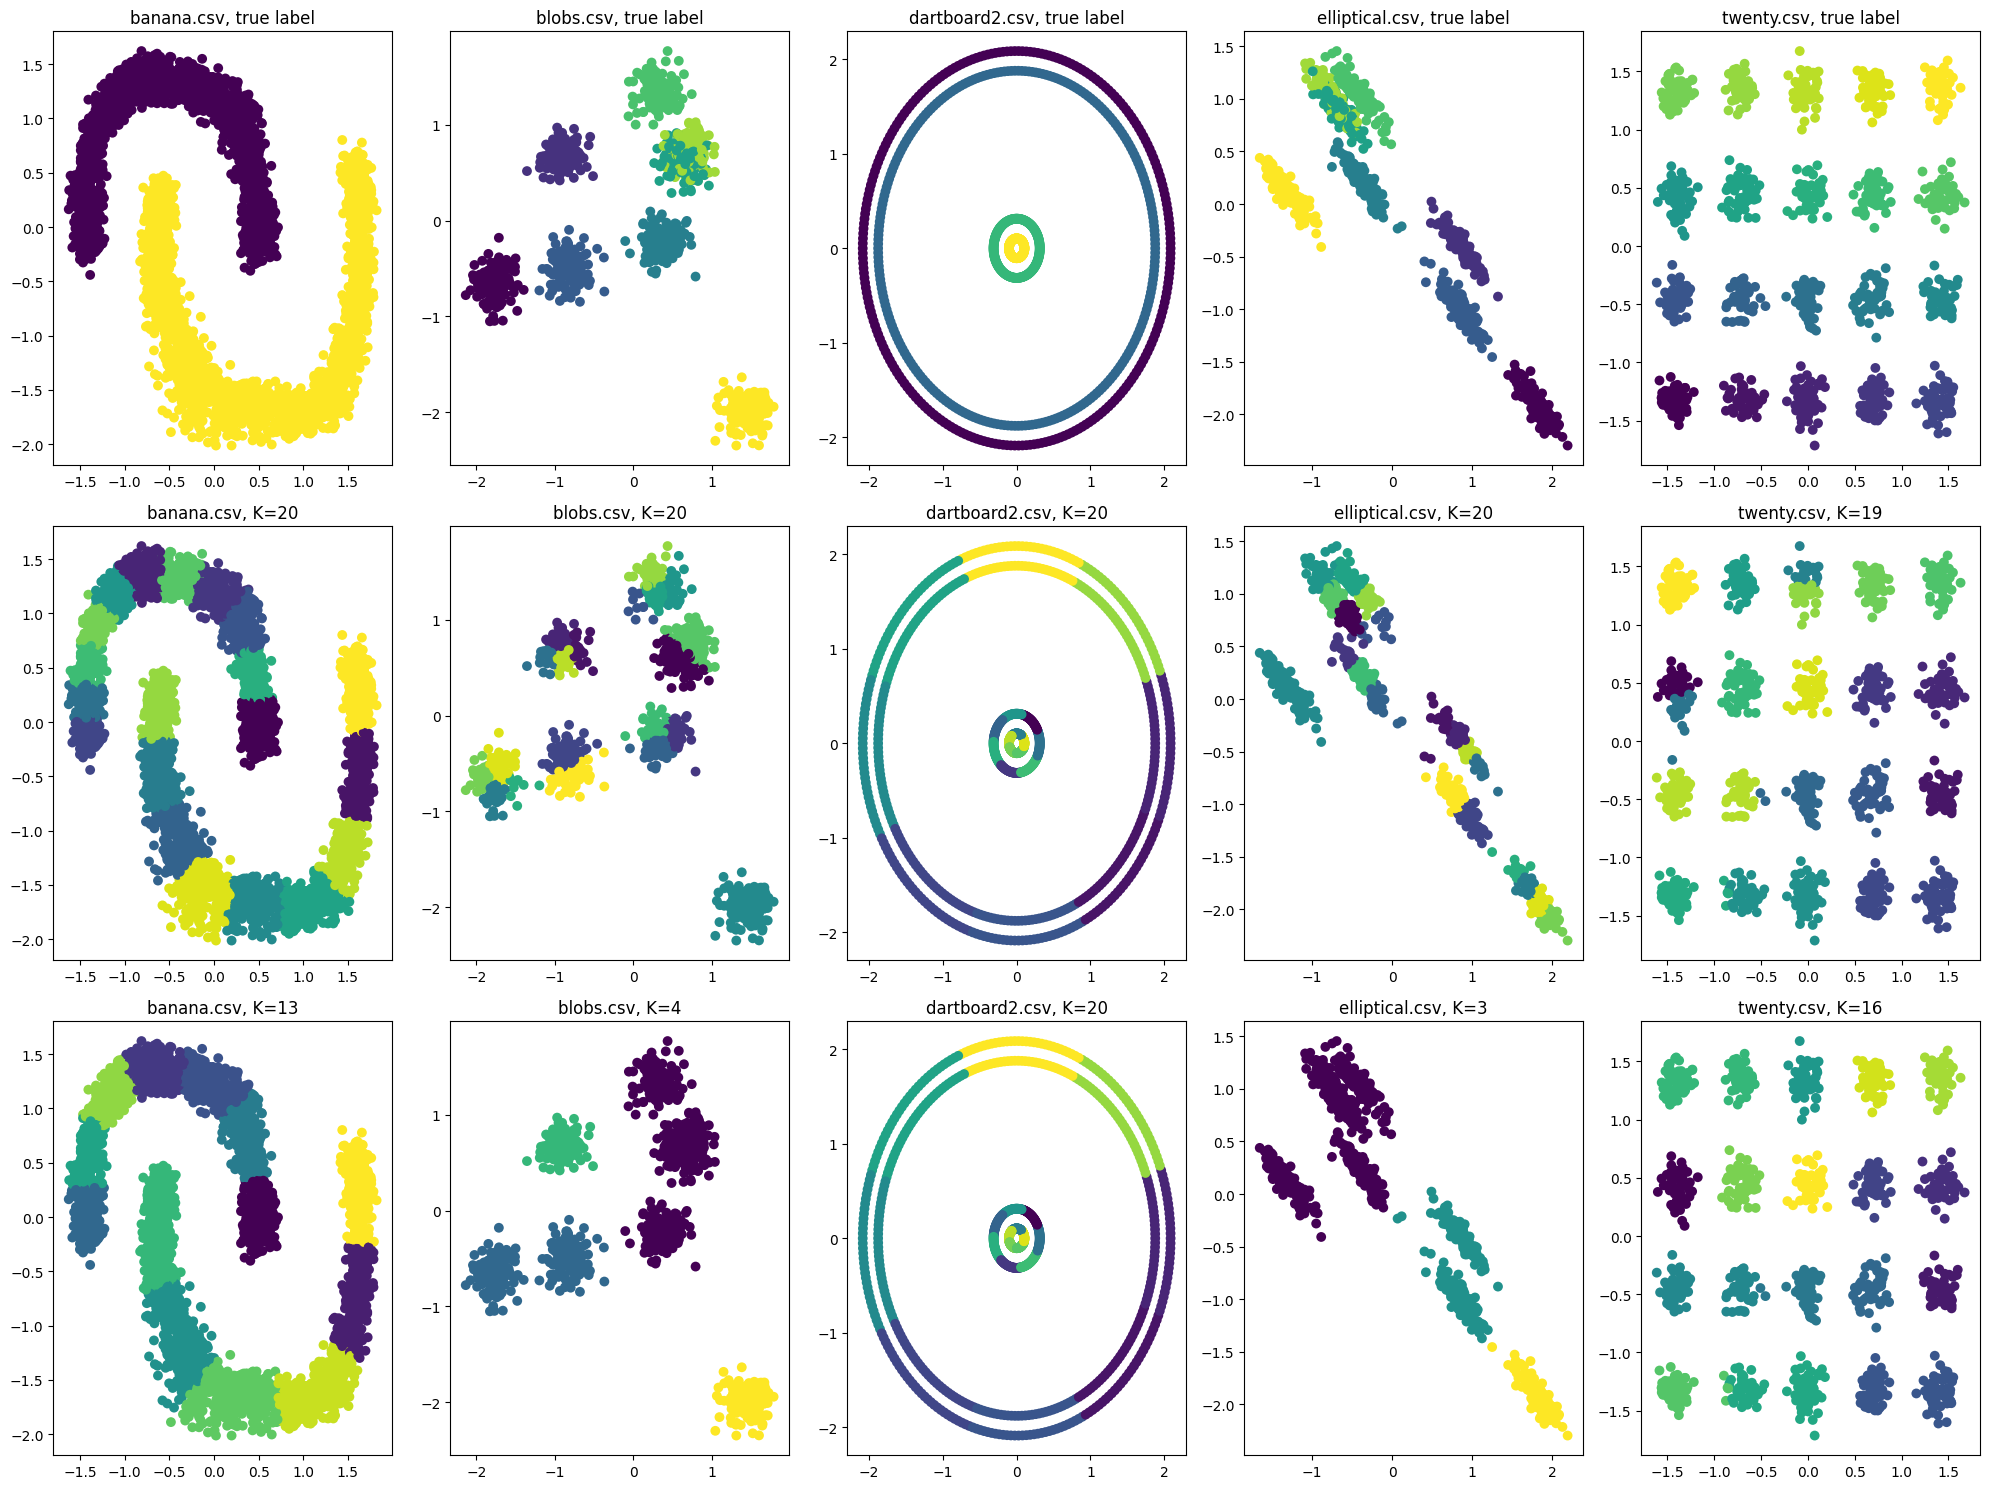

In [49]:
fig, axs = plt.subplots(3, len(datasets), figsize=(20, 15))  
for j, (dataset, labels) in enumerate(datasets):
    axs[0, j].scatter(dataset.iloc[:, 0], dataset.iloc[:, 1], c=labels, cmap='viridis', s=50, edgecolors='k', linewidth=0)
    axs[0, j].set_title(f'{datasets_path[j]}, true label')
    
for i , best_k in enumerate([wcss_best_k, dbi_best_k]):
    for j, (dataset, labels) in enumerate(datasets):
        kmeans = KMeans(best_k[j], random_state=42)
        y_pred = kmeans.fit_predict(dataset.values)
        axs[i+1, j].scatter(dataset.iloc[:, 0], dataset.iloc[:, 1], c=y_pred, cmap='viridis', s=50, edgecolors='k', linewidth=0)
#         plot_kmeans_clusters(dataset, kmeans.centroids,best_k[j] y_pred, ax=axs[i, j])
        axs[i+1, j].set_title(f'{datasets_path[j]}, K={best_k[j]}')

plt.tight_layout()
plt.show()
        